In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import random
import seaborn
import datetime as dt
from tsmoothie.smoother import *
from scipy.stats import gaussian_kde
# NOTE: I am ignoring some of the max iteration warnings that come from nmf
warnings.filterwarnings("ignore")

cwd = os.getcwd()
par = os.path.join(cwd, os.pardir)
sys.path.append(par)

# I made some modules to make importing easier and to have a nice class
# that does all the matrix operations
import matrix_operation
import Dataset
import state_set

In [2]:
# Just to reload the modules I imported above so I dont need to restart the kernel after making changes
import importlib
importlib.reload(matrix_operation)
importlib.reload(Dataset)
importlib.reload(state_set)

from matrix_operation import mat_opr
from Dataset import dataset
from state_set import state_data

curr = os.getcwd()
par = os.path.dirname(curr)

### Import and combine NYT and Big10

In [3]:
# hopefully this works on with your directory structure
# dset.nyt_df : NYT data
# dset.big10_df : Big10 data
# dset.combined and dset.dataframe are the combined version
dset = dataset()

# drop all zero rows and columns
dset.drop_zero_rows()
dset.drop_zero_cols()

# drop all rows where Big10 isn't complete
dset = dset.drop_bad_rows()

In [4]:
# NOTE: this is just so I can visualize the input along with the
#       normalized outputs. Should not be used elsewhere


n = dset.dataframe.copy(deep=True)

for i in n.columns:
    n[i] /= n[i].max()

inp = mat_opr(n).dataframe

### Interpolate using Isotonic + normalize

In [5]:
# doing isotonic first ensures that the last value is the greatest.
with_iso = dset.iso(unk=0)
normed = with_iso.normalizer()
normed.drop_zero_cols(val=1)

### Choose a rank:

In [6]:
errors = []
for i in range(10):
    nmfed = normed.sci_nmf(components=i+1)
    errors.append(normed.mean_square_error(nmfed, 0))

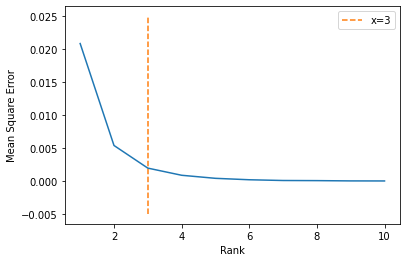

In [10]:
plt.plot(list(range(1,11)), errors)
plt.vlines(x=3, ymin=-0.005, ymax= 0.025, color="tab:orange", linestyle='dashed', label="x=3")
plt.xlabel("Rank")
plt.ylabel("Mean Square Error")
plt.legend()
plt.show()

In [11]:
ranker = 3

### Look at the basis vectors

In [12]:
X,Y = normed.sci_nmf(ranker, separate=True)
dotted = pd.DataFrame(np.dot(X,Y))
dotted.index = normed.dataframe.index
dotted.columns = normed.dataframe.columns
iso_nmf = mat_opr(dotted)

<AxesSubplot:title={'center':'Boston University'}>

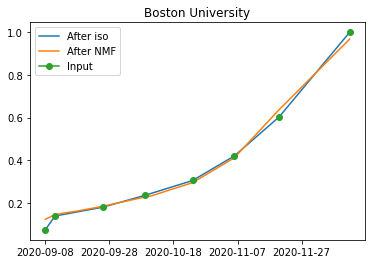

In [13]:
bu = pd.concat([inp['Boston University'],normed.dataframe['Boston University'], iso_nmf.dataframe['Boston University']], axis = 1)
bu.columns = ['Input','After iso','After NMF']

bu.drop('Input',1).plot(kind = 'line',legend=True, title = 'Boston University')

bu['Input'] = bu['Input'].replace(0,np.nan)
bu['Input'].plot(marker='o',legend=True)

## Clustering

In [14]:
def sort_by_cluster(labels):
    #helper function to see which columns are in which cluster
    cluster_dict = {lab:[] for lab in labels.value_counts().index}
    for i in range(len(labels)):
        cluster_dict[labels[i]].append(i) 
    return cluster_dict

In [15]:
def plot_cluster(data_obj, labels, mean = False, sample_size = 10,legend=False, 
                 ylimit=None, axer=None, ylabel=None, title = None):
    
    # plots a sample of data (or the mean of that sample) based on clustering results
    subs = labels.value_counts()
    if axer is None:
        fig, axer = plt.subplots(len(subs), figsize=(14,12))
        
    if ylimit is not None:
        for a in axer:
            a.set_ylim([0,ylimit])     
            
    clust_dict = sort_by_cluster(labels)
    

    for i in clust_dict.keys():
        if sample_size > len(clust_dict[i]):
            for j in clust_dict[i]:
                data_obj.dataframe.iloc[:,j].plot(ax=axer[i], legend = legend)
        else:
            samples = random.sample(clust_dict[i], sample_size)
            for j in samples:
                data_obj.dataframe.iloc[:,j].plot(ax=axer[i], legend=legend)
        if title is not None:
            axer[i].set_title("Cluster " + str(i) + " " + title)
        else:
            axer[i].set_title("Cluster " + str(i))
            
        if ylabel is not None:
            axer[i].set_ylabel(ylabel)
            
    if mean:
        for k in clust_dict.keys():
            meaner = data_obj.dataframe.iloc[:,clust_dict[k]].mean(axis=1)
            meaner.plot(ax=axer[k], color='k', linewidth=4.0, label='center', legend=legend)

In [16]:
#kmeans = KMeans(n_clusters=3, random_state=9).fit(np.transpose(np.array(with_iso.array)))
#county = pd.Series(kmeans.labels_)
#plot_cluster(iso_nmf, county,mean=True, sample_size=10)

### Cluster the vectors of Y after decomposition

In [17]:
indexy = []
for i in range(ranker):
    indexy.append("basis " + str(i))

In [18]:
y_table = mat_opr(pd.DataFrame(Y, index = indexy))
y_clust = np.transpose(np.array(y_table.array))

### Number of Clusters?

For n_clusters = 2 The average silhouette_score is : 0.4989649288646961
For n_clusters = 3 The average silhouette_score is : 0.42109173214668794
For n_clusters = 4 The average silhouette_score is : 0.36407182273008


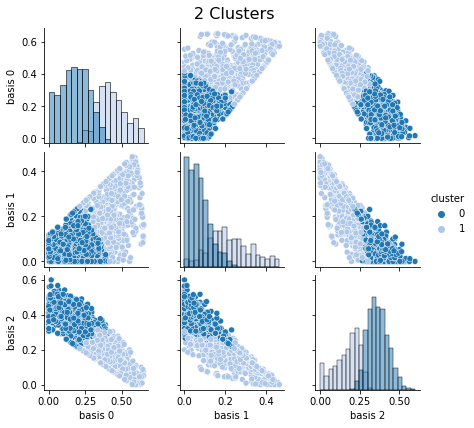

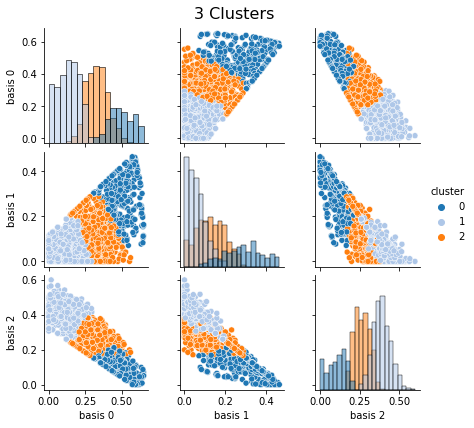

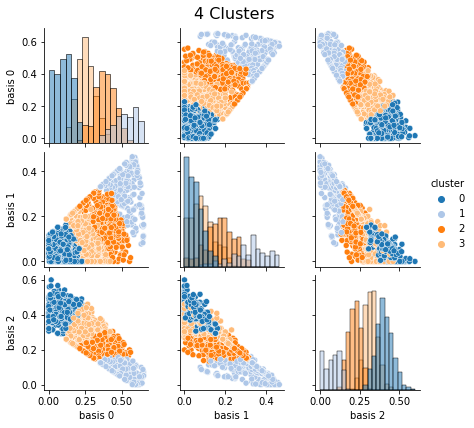

In [19]:
ns = [2,3,4]
silhouette = {}

for n in ns:
    kmeans = KMeans(n_clusters=n, random_state=9).fit(y_clust)
    n_counter = pd.Series(kmeans.labels_)
    
    silhouette_avg = silhouette_score(y_clust, n_counter)
    print("For n_clusters =", n,
          "The average silhouette_score is :", silhouette_avg)
    silhouette[n] = silhouette_avg
    n_cluster_df = y_table.dataframe.T
    n_cluster_df['cluster'] = n_counter

    pp = seaborn.pairplot(n_cluster_df, hue="cluster", diag_kind="hist", height=2, aspect=1,palette='tab20')

    fig = pp.fig
    fig.subplots_adjust(top=0.93, wspace=0.3)
    t = fig.suptitle(str(n) + " Clusters", fontsize=16)

In [20]:
# Take the number of clusters to be the max silhouette score
num_clust = max(silhouette, key=silhouette.get)

In [21]:
# clustering:
kmeans = KMeans(n_clusters=num_clust, random_state=9, max_iter=1000).fit(y_clust)
counter = pd.Series(kmeans.labels_)

### Pairwise Distance matrix:

In [22]:
# This takes a while because I did the simple O(n^2) implementation
input_pair_dist = normed.pairwise_distance()
factor_pair_dist =  y_table.pairwise_distance()

In [23]:
# rearrange pair_dist so that all columns/rows belonging to cluster 0 come before the ones correspoinding to cluster 1, etc.
# graph and expect to see small distance on the diagonals and larger everywhere else
# take a sample of 100 to graph otherwise this is too big

input_pair_dist.columns = range(len(input_pair_dist.columns))

order = []
for h in range(num_clust):
    order += counter.loc[counter == h].index.to_list()

input_pair_dist = input_pair_dist[order]
input_pair_dist = input_pair_dist.reindex(order)
factor_pair_dist = factor_pair_dist[order]
factor_pair_dist = factor_pair_dist.reindex(order)

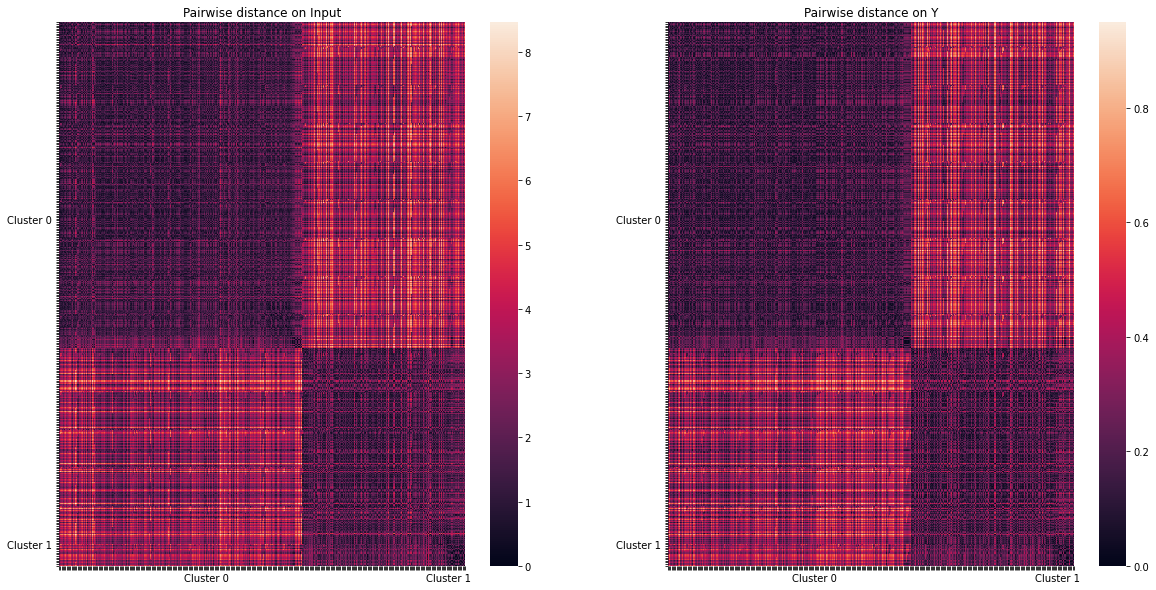

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))
seaborn.heatmap(input_pair_dist, ax = ax1)
seaborn.heatmap(factor_pair_dist, ax = ax2)

# lot of work to get the x/yticks nice
tot = len(input_pair_dist.columns)
fracs = [va/tot for va in counter.value_counts().to_list()]
l_m = round(np.lcm.reduce(counter.value_counts().to_list())/tot)

for axy in [ax1, ax2]:
    axy.xaxis.set_major_locator(plt.MaxNLocator(l_m))
    axy.yaxis.set_major_locator(plt.MaxNLocator(l_m))

labs = ['']*l_m
so_far = 0
for f in range(len(fracs)):
    pos = round(l_m*(fracs[f]/2 + so_far))
    labs[pos] = 'Cluster ' + str(f)
    so_far += fracs[f]

ax1.set_xticklabels(labs, rotation= 0);
ax2.set_xticklabels(labs, rotation= 0);
ax1.set_yticklabels(labs);
ax2.set_yticklabels(labs);
"""
xlabs = ['']*9+ ['cluster 0'] + ['']*14 + ['cluster 1'] + ['']*5
ylabs = ['']*13 + ['cluster 0'] + ['']*27 + ['cluster 1'] + ['']*12
ax1.set_xticklabels(xlabs, rotation= 0);
ax2.set_xticklabels(xlabs, rotation= 0);
ax1.set_yticklabels(ylabs);
ax2.set_yticklabels(ylabs);
"""
ax1.set_title('Pairwise distance on Input');
ax2.set_title('Pairwise distance on Y');

### Clustering results for the vectors of Y after decomposition:

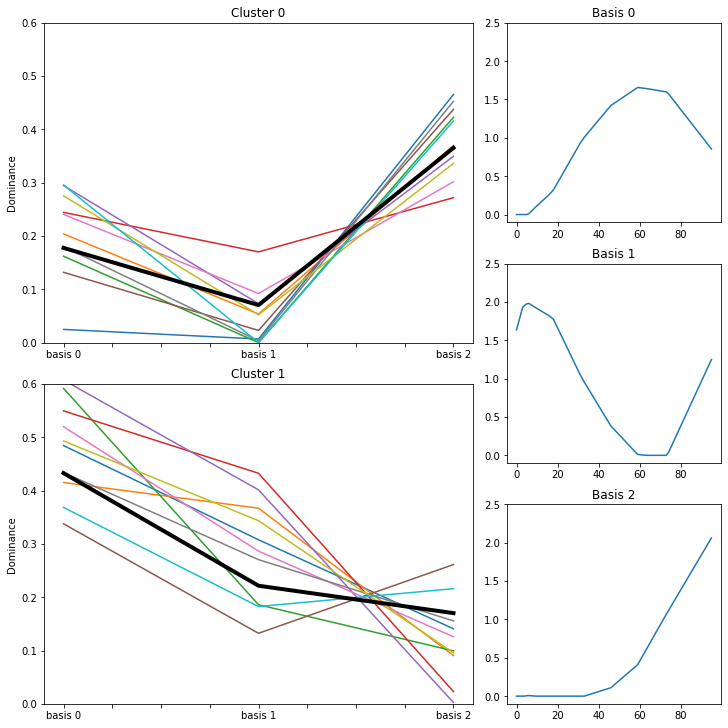

In [25]:
basis_fig = plt.figure(1, constrained_layout=True, figsize = (10,10))

gs = basis_fig.add_gridspec(6,3)
bx1 = basis_fig.add_subplot(gs[:3,0:2])
bx2 = basis_fig.add_subplot(gs[3:6,0:2])
bx3 = basis_fig.add_subplot(gs[:2,2])
bx4 = basis_fig.add_subplot(gs[2:4,2])
bx5 = basis_fig.add_subplot(gs[4:6,2])
plot_cluster(y_table, counter, mean=True, ylimit = 0.6,axer=[bx1, bx2],
            ylabel = "Dominance")

baser = pd.DataFrame(X)
basis_subs = [bx3, bx4, bx5]
for b in baser.columns:
    baser[b].plot(ax = basis_subs[b], title="Basis " + str(b))
    basis_subs[b].set_ylim([-0.1,2.5])

### Plot case curves based on their cluster of Y

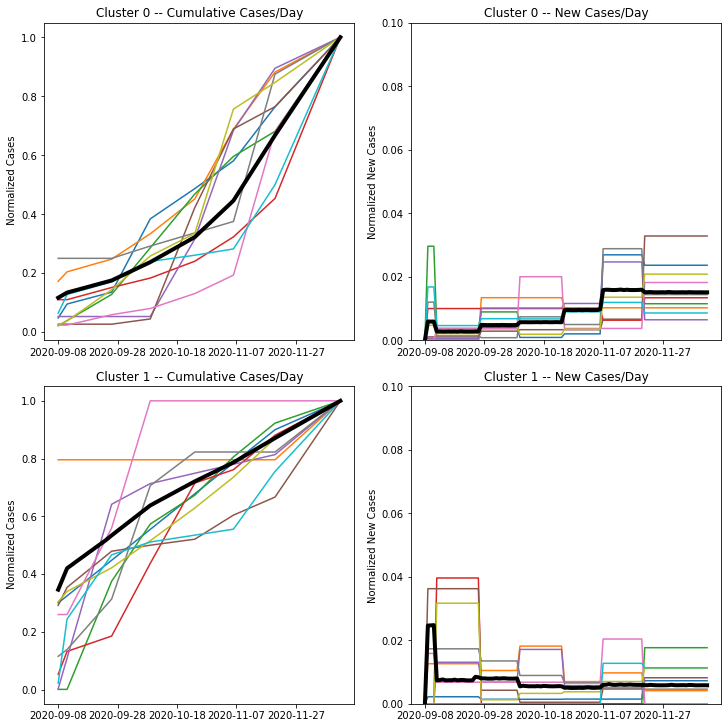

In [26]:
case_fig = plt.figure(1, constrained_layout=True, figsize = (10,10))
cs = case_fig.add_gridspec(2,2)
cx1 = case_fig.add_subplot(cs[0,0])
cx2 = case_fig.add_subplot(cs[1,0])
cx3 = case_fig.add_subplot(cs[0,1])
cx4 = case_fig.add_subplot(cs[1,1])


plot_cluster(normed, counter, mean=True,axer=[cx1, cx2], 
             ylabel = " Normalized Cases", title = "-- Cumulative Cases/Day")

new_case = normed.new_case_calc()
plot_cluster(new_case, counter, mean=True, legend=False, 
             ylimit = .10,axer=[cx3,cx4], ylabel = "Normalized New Cases",
            title = "-- New Cases/Day")
plt.show()

In [27]:
counter.value_counts()[0]

988

In [28]:
#plot_cluster(normed, counter, mean=True)

In [29]:
#new_case = normed.new_case_calc()
#plot_cluster(new_case, counter, mean=True, ylimit=0.1)

## Compare with Reopening Plans:

In [30]:
# Bring in the reopening plan data
rep = os.path.join(par, "other_data", "clean_reopen_plans.csv")
reopen = pd.read_csv(rep, index_col = 0)
reopen["Date"] = pd.to_datetime(reopen["Date"])
reopen = reopen.drop(reopen.loc[reopen.Date < dt.datetime(2020, 9, 8)].index)
reopen.index = range(len(reopen.index))

big_ten_names = {'University of Maryland, College Park':'Maryland','Michigan State University':'Michigan State',
                'University of Minnesota Twin Cities':'Minnesota', 'Northwestern University':'Northwestern',
                'University of Illinois Urbana-Champaign':'Illinois','University of Wisconsin-Madison':'UW-Madison',
                'University of Michigan':"Michigan"}
for n in big_ten_names.keys():
    reopen = reopen.replace(n, big_ten_names[n])

In [31]:
rep_dat = {i:[0,0] for i in range(num_clust)}
reopen["Cluster"] = [-1]*len(reopen.index)

for s in reopen.School.value_counts().index:
    rows = reopen.loc[reopen.School == s]
    try: 
        int_loc = normed.dataframe.columns.get_loc(s)
        for r in rows.index:
            proc = reopen.iloc[r,2]
            clustery = counter[int_loc]

            if proc == 'closing':
                rep_dat[clustery][1] += 1
            else:
                rep_dat[clustery][0] += 1

            reopen.iloc[r,6] = clustery
    except:
        reopen = reopen.drop(reopen.loc[reopen.School == s].index, axis=0)

# Normalize (divide by number of schools in each cluster)
for k in rep_dat.keys():
    rep_dat[k] = [j/counter.value_counts()[k] for j in rep_dat[k]]

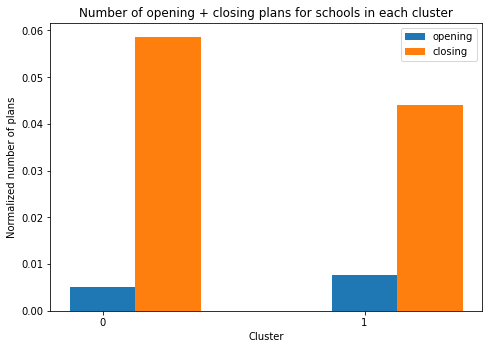

In [32]:
Z = np.arange(num_clust)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(Z + 0.00, [rep_dat[i][0] for i in rep_dat.keys()], color = 'tab:blue', width = 0.25, label = 'opening')
ax.bar(Z + 0.25, [rep_dat[i][1] for i in rep_dat.keys()], color = 'tab:orange', width = 0.25, label = 'closing')
ax.set_xticks([0,1])
ax.set_ylabel("Normalized number of plans")
ax.set_xlabel('Cluster')
ax.set_title("Number of opening + closing plans for schools in each cluster")
plt.legend()

### When did changes occur?

range(0, 2)
0
1


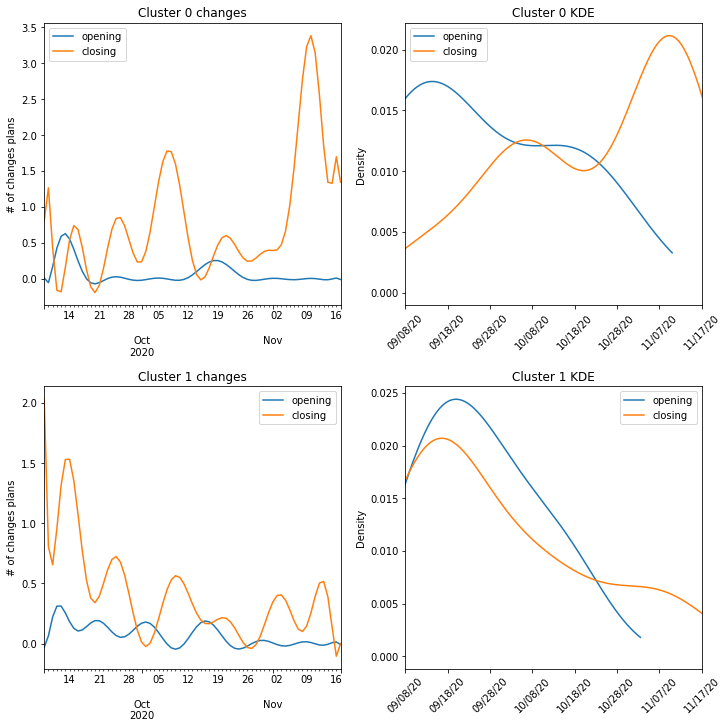

In [33]:
rep_fig = plt.figure(1, constrained_layout=True, figsize = (10,10))
rs = rep_fig.add_gridspec(2,2)
rx1 = rep_fig.add_subplot(rs[0,0])
rx2 = rep_fig.add_subplot(rs[1,0])
rx3 = rep_fig.add_subplot(rs[0,1])
rx4 = rep_fig.add_subplot(rs[1,1])

print(range(num_clust))

for c in range(num_clust):
    subs = [rx1, rx3] if c == 0 else [rx2, rx4]

    plot_dict = {date:[0,0] for date in pd.date_range(start="2020-09-08",end="2020-11-17").to_list()}
    clu = reopen.loc[reopen.Cluster == c]
    
    for ind in clu.index:
        typer = reopen.loc[ind,'Type']
        dater = reopen.loc[ind,'Date']
        if typer == 'closing':
            plot_dict[dater][1] += 1
        else:
            plot_dict[dater][0] += 1
            
    histy = pd.DataFrame.from_dict(plot_dict, columns=['opening','closing'], orient="index")
    #histy = histy.replace(0,np.nan)

    open_dist = []
    close_dist = []
    for indy in range(len(histy.index)):
        if not np.isnan(histy.iloc[indy,0]):
            for o in range(int(histy.iloc[indy, 0])):
                open_dist.append(indy)

        if not np.isnan(histy.iloc[indy, 1]):
            for ci in range(int(histy.iloc[indy,1])):
                close_dist.append(indy)

    
    odens = pd.Series(open_dist)
    odens.plot(kind='kde', xlim=(0,70), xticks = list(range(0,71))[::10],ax= subs[1], label='opening', legend=True)
    cdens = pd.Series(close_dist)
    cdens.plot(kind='kde', xlim=(0,70), xticks = list(range(0,71))[::10],ax= subs[1],label='closing', legend=True)
    
    dates = [i.strftime("%m/%d/%y") for i in list(histy.index)[::10]]
    subs[1].set_xticklabels(dates,rotation=45)
    subs[1].set_title("Cluster " + str (c) + " KDE")

    #histy /= counter.value_counts()[c] #Normalize by dividing by the number of schools
    
    smoother = GaussianSmoother(n_knots = 20, sigma=0.05)
    #sig_dates = histy['opening'].dropna()
    smoother.smooth(histy['opening'])
    histy.loc[:,'opening'] = smoother.smooth_data[0]
    #sig_dates = histy['closing'].dropna()
    smoother.smooth(histy['closing'])
    histy.loc[:,'closing'] = smoother.smooth_data[0]

    
    histy.plot(ax = subs[0],kind='line', ylabel="# of changes plans")#, ylim = [-0.0001, 0.0025])
    subs[0].set_title("Cluster " + str(c) + " changes")
    print(c)